https://dataspace.princeton.edu/jspui/handle/88435/dsp01rv042w888

README.TXT from dataset:

The file in this repository contains 276 flies collected for Coen et al 2014 [1] in a v7.3 MATLAB .mat file compressed as a .tar.gz. Each member of the structure contains values for all 17 movement features described in the associated manuscript. These are:

mFV/fFV - male/female forward velocity
mLS/fLS - male/female lateral speed
mfAngle/fmAngle - male (female) angle relative to the centroid of the female (male)
mFA/fFA - male/female forward acceleration
mLA/fLA - male/female lateral acceleration
mfDist - distance between the male and the female
mfFV/fmFV - component of the male (female) velocity in the direction of the female (male)
mfLV/fmLV - component of the male (female) velocity orthogonal to the female (male)
mRS/fRS - male/female rotational speed

In addition, song was recorded and stored at a different rate (10 kHz). The center of each detected pulse is in the 'pulseTimes' field while the start and end of each detected run of sine song is in 'sineTimes'. Song recorded at 10 kHz can be converted into the 'frames' of the features using the frame rate in the 'fps' field.

Copulation was manually scored and reported in the 'copulationFrame' field. The strain of the animal is reported in the 'strain' field.


[1] Coen, Clemens, Weinstein, Pacheco, Deng, Murthy. Dynamic sensory cues shape song structure in Drosophila. Nature, 507 (7491):233-237, March 2014.

## My song conventions
Silent = 0, sine = 1, pulse_slow = 2, pulse_fast = 3

Note: melanogaster interpulse interval ~ 35 ms

In [1]:
%matplotlib inline
from itertools import product as cprod
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import sys
from scipy import signal
from scipy import stats


from aux import Generic, loadmat_h5
from disp import set_font_size, get_line

cc = np.concatenate


STRAINS = ['NM91', 'CarM03', 'CM07', 'CSTul', 'N30', 'ZH23', 'ZW109' , 'WTG']

# Basic data parameters

In [2]:
NTR = 276  # total num trials
FPS = 30.03  # Hz (property of data, don't change)
DT = 1/FPS  # sec

PULSE_SMOOTH = 1  # number of consecutive 30 Hz time bins to assign P when pulse occurs

In [3]:
all_data = loadmat_h5('data/original/coen_behav/nat_neuro_pairs/behav.mat')

In [4]:
def get_tr(itr):
    d_tr = {}
    for k in all_data['flyData'].keys():
        d_tr[k] = np.array(all_data['flyData'][k][0][itr]).squeeze()
        
    # clean a bit
    if d_tr['sineTimes'].ndim == 1:
        d_tr['sineTimes'] = d_tr['sineTimes'][None, :]

    # convert song times to sec
    d_tr['pulseTimes'] /= 1e4
    d_tr['sineTimes'] /= 1e4

    # make time array
    d_tr['nFrame'] = len(d_tr['fA'])
    d_tr['t'] = np.arange(d_tr['nFrame'], dtype=float) / d_tr['fps']

    # make song array same shape as other vars
    d_tr['s'] = np.zeros(len(d_tr['fA']), dtype=int)  # silent

    # fill in sine times
    for start, end in d_tr['sineTimes']:
        d_tr['s'][(start <= d_tr['t']) & (d_tr['t'] < end)] = 1  # sine

    # fill in pulse times
    for pt, ptype in zip(d_tr['pulseTimes'], d_tr['pulseType']):
        it = int(np.round(pt*d_tr['fps']))
        try:
            for it_ in range(PULSE_SMOOTH):
                d_tr['s'][it-it_] = 2 + ptype
        except IndexError:
            pass
        
    return d_tr

In [5]:
tr_all = [get_tr(itr) for itr in range(NTR)]
expts = [f'expt_{c}' for c in range(len(tr_all))]

In [6]:
tr_example = tr_all[0]  # example trial
print(tr_example['s'])  # song
print(tr_example['mfDist'])  # dist btwn male and female
print(tr_example.keys())  # all observables

[0 0 0 ... 0 0 0]
[4.072 3.744 3.893 ... 2.521 2.524 2.554]
dict_keys(['copulationFrame', 'fA', 'fFA', 'fFV', 'fLA', 'fLS', 'fRS', 'fV', 'fmAngle', 'fmFV', 'fmLV', 'fps', 'mA', 'mFA', 'mFV', 'mLA', 'mLS', 'mRS', 'mV', 'mfAngle', 'mfDist', 'mfFV', 'mfLV', 'pulseTimes', 'pulseType', 'sineTimes', 'strain', 'nFrame', 't', 's'])


Save strain mask

In [7]:
strains = np.array([str(tr['strain']) for tr in tr_all])
strains = cc([strains, np.repeat('WTG', 84)])
print(strains)

df = pd.DataFrame(columns=['ID', 'STRAIN'], data={'ID': np.arange(276+84), 'STRAIN': strains})
df.to_csv('data/simple/strains.csv', index=False)

['NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91'
 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91'
 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91'
 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91'
 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'NM91' 'CarM03' 'CarM03'
 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03'
 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03'
 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03'
 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03'
 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03' 'CarM03'
 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07'
 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07'
 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07'
 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CM07' 'CSTul' 'CSTul' 'CST

# Examples

In [7]:
songs = [_tr['s'] for _tr in tr_all]
ffvs = [_tr['fFV'] for _tr in tr_all]
ffas = [_tr['fFA'] for _tr in tr_all]
flss = [_tr['fLS'] for _tr in tr_all]
frss = [_tr['fRS'] for _tr in tr_all]
fmfvs = [_tr['fmFV'] for _tr in tr_all]
fmlss = [np.abs(_tr['fmLV']) for _tr in tr_all]

In [8]:
# fill single-timestep gaps between pulses
s_filled = []
for s in songs:
    s_tmp = s.copy()
    
    for it in (s == 2).nonzero()[0]:  # slow pulses
        if it >= len(s) - 2:  # too close to end
            continue
            
        if (s[it+1] == 0) and (s[it+2] in [2, 3]):  # if followed by blank then pulse
            s_tmp[it+1] = 2  # fill with slow pulse
                
    for it in (s == 3).nonzero()[0]:
        if it >= len(s) - 2:  # too close to end
            continue
            
        if (s[it+1] == 0) and (s[it+2] in [2, 3]):  # if followed by blank then pulse
            s_tmp[it+1] = 3  # fill with fast pulse
            
    s_filled.append(s_tmp)
songs = s_filled

In [9]:
# convert to data frames
cols = ['ID', 'FRAME', 'T', 'Q', 'S', 'P', 'F', 'FFV', 'FFA', 'FLS', 'FRS', 'FMFV', 'FMLS']
dfs = []
for ctr in range(len(songs)):
    df = pd.DataFrame({
        'ID': np.repeat(ctr, len(songs[ctr])),
        'FRAME': np.arange(len(songs[ctr]), dtype=int),
        'T': np.arange(len(songs[ctr]))/FPS,
        'Q': (songs[ctr] == 0).astype(int),
        'S': (songs[ctr] == 1).astype(int),
        'P': (songs[ctr] == 2).astype(int),
        'F': (songs[ctr] == 3).astype(int),
        'FFV': ffvs[ctr],
        'FFA': ffas[ctr],
        'FLS': flss[ctr],
        'FRS': frss[ctr],
        'FMFV': fmfvs[ctr],
        'FMLS': fmlss[ctr],
    })
    dfs.append(df)

In [10]:
df_cc = pd.concat(dfs, ignore_index=True)
df_cc

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [11]:
df_cc.to_csv('data/simple/c_song_f_behav.csv', index=False)

In [12]:
# test whether save was done correctly
df_load = pd.read_csv('data/simple/c_song_f_behav.csv')
df_load

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


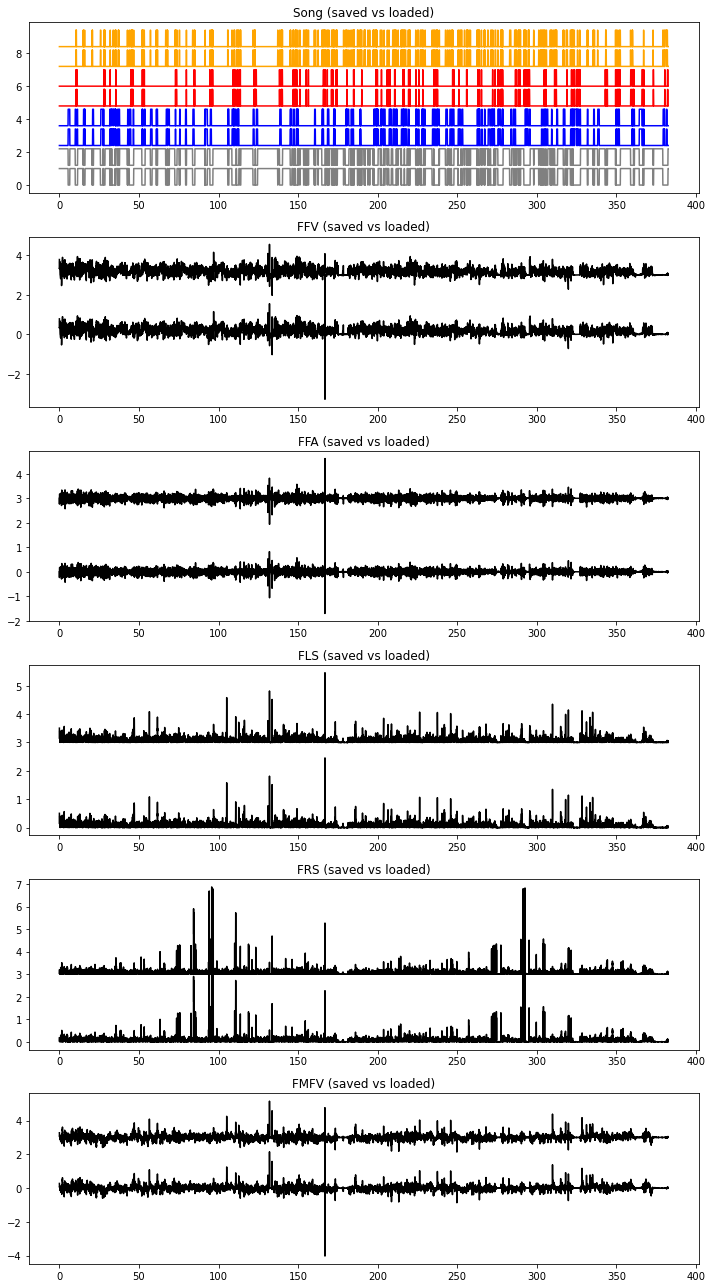

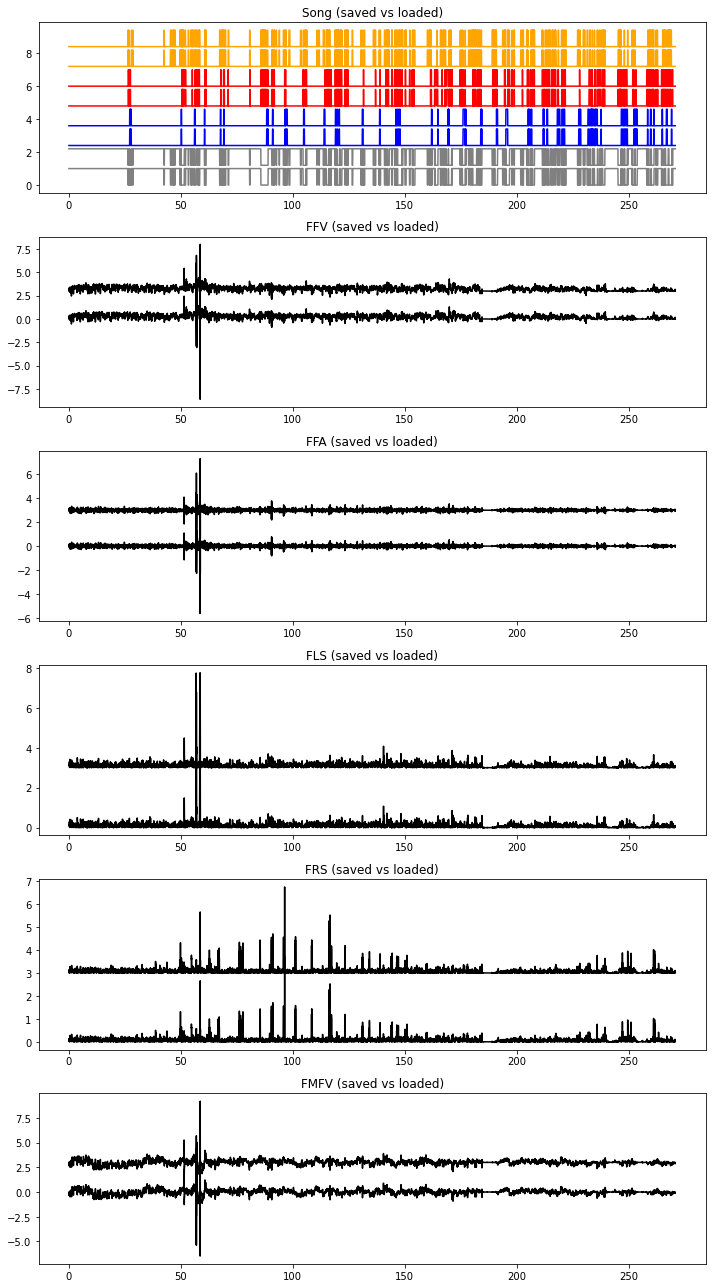

In [13]:
for ID in [3, 100]:
    fig, axs = plt.subplots(6, 1, figsize=(10, 18), tight_layout=True)
    axs[0].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID].Q, c='gray')
    axs[0].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID].Q + 1.2, c='gray')
    axs[0].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID].S + 2.4, c='b')
    axs[0].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID].S + 3.6, c='b')
    axs[0].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID].P + 4.8, c='r')
    axs[0].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID].P + 6, c='r')
    axs[0].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID].F + 7.2, c='orange')
    axs[0].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID].F + 8.4, c='orange')
    axs[0].set_title('Song (saved vs loaded)')
    
    axs[1].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID]['FFV'], c='k')
    axs[1].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID]['FFV'] + 3, c='k')
    axs[1].set_title('FFV (saved vs loaded)')
    
    axs[2].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID]['FFA'], c='k')
    axs[2].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID]['FFA'] + 3, c='k')
    axs[2].set_title('FFA (saved vs loaded)')
    
    axs[3].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID]['FLS'], c='k')
    axs[3].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID]['FLS'] + 3, c='k')
    axs[3].set_title('FLS (saved vs loaded)')
    
    axs[4].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID]['FRS'], c='k')
    axs[4].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID]['FRS'] + 3, c='k')
    axs[4].set_title('FRS (saved vs loaded)')
    
    axs[5].plot(df_cc[df_cc.ID == ID]['T'], df_cc[df_cc.ID == ID]['FMFV'], c='k')
    axs[5].plot(df_load[df_load.ID == ID]['T'], df_load[df_load.ID == ID]['FMFV'] + 3, c='k')
    axs[5].set_title('FMFV (saved vs loaded)')